In [1]:
# CORE LIBRARIES
import os
import re
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP LIBRARIES
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# SKLEARN (Traditional ML)
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# UTILITIES
import joblib  # for saving trained models

import pickle

# CONFIGURATION
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

warnings.filterwarnings("ignore")


In [2]:
# Dataset Loading and Overview

# Load all datasets
df1 = pd.read_excel("CyberBulling_Dataset_Bangla.xlsx", engine='openpyxl')
df2 = pd.read_excel("cyberbulling bangla dataset.xlsx", engine='openpyxl')
df3 = pd.read_csv("cyberbullying_tweets.csv", encoding='utf-8', encoding_errors='ignore')
df4 = pd.read_csv("romanized_bangla_bullying.csv", encoding='utf-8', on_bad_lines='skip')

In [3]:
# Check columns
print(df1.columns)
print(df2.columns)
print(df3.columns)
print(df4.columns)

#check data shape
print('df1:',df1.shape)
print('df2:',df2.shape)
print('df3:',df3.shape)
print('df4:',df4.shape)

Index(['Unnamed: 0', 'Description', 'Label'], dtype='object')
Index(['comment', 'Category', 'Gender', 'comment react number', 'label'], dtype='object')
Index(['tweet_text', 'cyberbullying_type'], dtype='object')
Index(['text', 'label'], dtype='object')
df1: (6010, 3)
df2: (44001, 5)
df3: (47692, 2)
df4: (20000, 2)


In [4]:
# Explore unique label names
print("Dataset 1 labels:", df1['Label'].unique())
print("Dataset 2 labels:", df2['label'].unique())
print("Dataset 3 labels:", df3['cyberbullying_type'].unique())
print("Dataset 4 labels:", df4['label'].unique())

Dataset 1 labels: ['sexual' 'Threat' 'Political' 'troll' 'Neutral']
Dataset 2 labels: ['religious' 'not bully' 'troll' 'sexual' 'threat']
Dataset 3 labels: ['not_cyberbullying' 'gender' 'religion' 'other_cyberbullying' 'age'
 'ethnicity']
Dataset 4 labels: ['not bullying' 'bullying']


In [5]:
# Label Normalization Function
def normalize_label(label):
    label = str(label).lower().strip()
    if label in ['neutral', 'not bully', 'not_cyberbullying', 'not bullying']:
        return 'Approved'        # Not Bullying
    else:
        return 'Not Approved'    # Bullying

# Apply normalization to each dataset
df1['final_label'] = df1['Label'].apply(normalize_label)
df2['final_label'] = df2['label'].apply(normalize_label)
df3['final_label'] = df3['cyberbullying_type'].apply(normalize_label)
df4['final_label'] = df4['label'].apply(normalize_label)   

# Check distribution
print("Dataset 1:\n", df1['final_label'].value_counts(), "\n")
print("Dataset 2:\n", df2['final_label'].value_counts(), "\n")
print("Dataset 3:\n", df3['final_label'].value_counts(), "\n")
print("Dataset 4:\n", df4['final_label'].value_counts(), "\n")   


Dataset 1:
 final_label
Not Approved    4809
Approved        1201
Name: count, dtype: int64 

Dataset 2:
 final_label
Not Approved    28661
Approved        15340
Name: count, dtype: int64 

Dataset 3:
 final_label
Not Approved    39747
Approved         7945
Name: count, dtype: int64 

Dataset 4:
 final_label
Approved        10093
Not Approved     9907
Name: count, dtype: int64 



In [6]:
# Language Filtering

# Bangla / English detector
def is_bangla(text):
    return bool(re.search('[\u0980-\u09FF]', str(text)))

def is_english(text):
    return bool(re.search('[a-zA-Z]', str(text)))

# Apply detection for df1, df2, df3
for df in [df1, df2, df3]:
    df['language'] = df['Description' if 'Description' in df.columns else 
                        'comment' if 'comment' in df.columns else 
                        'tweet_text'].apply(
        lambda x: 'BN' if is_bangla(x) else ('EN' if is_english(x) else 'OTHER')
    )

# Filter only Bangla and English for these datasets
df1 = df1[df1['language'].isin(['BN', 'EN'])]
df2 = df2[df2['language'].isin(['BN', 'EN'])]
df3 = df3[df3['language'].isin(['BN', 'EN'])]

# Manually tag Romanized Bangla dataset 
df4['language'] = 'RN'

print("Language filtering done.")

# Check Unique languages per dataset
print("Unique languages per dataset:")
print("df1:", df1['language'].unique())
print("df2:", df2['language'].unique())
print("df3:", df3['language'].unique())
print("df4:", df4['language'].unique())

Language filtering done.
Unique languages per dataset:
df1: ['BN']
df2: ['BN']
df3: ['EN']
df4: ['RN']


In [7]:
#  Dataset Merging and Column Unification

# Unify column names for each dataset
df1_final = df1[['Description', 'final_label', 'language']].rename(columns={'Description': 'text', 'final_label': 'label'})
df2_final = df2[['comment', 'final_label', 'language']].rename(columns={'comment': 'text', 'final_label': 'label'})
df3_final = df3[['tweet_text', 'final_label', 'language']].rename(columns={'tweet_text': 'text', 'final_label': 'label'})
df4_final = df4[['text', 'final_label', 'language']].rename(columns={'final_label': 'label'})   # 🔹 Romanized Bangla

# Merge all datasets together
df = pd.concat([df1_final, df2_final, df3_final, df4_final], ignore_index=True)

print(" Final merged dataset shape:", df.shape)

# Preview merged data
df.head()

 Final merged dataset shape: (117677, 3)


,text,label,language
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Not Approved,BN
1,আপনার জন্ম প্রক্রিয়ার সময় আপনার মায়ের ভিতর কি ...,Not Approved,BN
2,ধজভংগ দের আর ভায়াগ্রা লাগবো না। ধংস হোক এই সব ...,Not Approved,BN
3,বোকাচোদা একটা।,Not Approved,BN
4,তোর দেশে ফেরার অপেক্ষায় রইলাম। জেলে একটা কামরা...,Not Approved,BN


In [8]:
# Basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117677 entries, 0 to 117676
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      117677 non-null  object
 1   label     117677 non-null  object
 2   language  117677 non-null  object
dtypes: object(3)
memory usage: 2.7+ MB
None


In [9]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
text        0
label       0
language    0
dtype: int64


In [10]:
# Duplicate check
duplicates = df.duplicated(subset='text').sum()
print("Duplicate rows:", duplicates)

Duplicate rows: 26303


In [11]:
# Remove duplicates 
df.drop_duplicates(subset='text', inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
# label distribution
print("\nLabel distribution:\n", df['label'].value_counts())


Label distribution:
 label
Not Approved    67930
Approved        23444
Name: count, dtype: int64


In [13]:
# language distribution
print("\nLanguage distribution:\n", df['language'].value_counts())


Language distribution:
 language
EN    45991
BN    45224
RN      159
Name: count, dtype: int64


In [14]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(df['label'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=df['label']
)
class_weight_dict = dict(zip(classes, class_weights))

print(class_weight_dict)


{'Approved': 1.9487715406927146, 'Not Approved': 0.6725599882231709}


In [15]:
# Empty text check
empty_rows = df[df['text'].str.strip() == ""]
print("\nEmpty text rows:", len(empty_rows))


Empty text rows: 0


In [16]:
# check dataset shape
df.shape

(91374, 3)

In [17]:
df.head()

,text,label,language
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Not Approved,BN
1,আপনার জন্ম প্রক্রিয়ার সময় আপনার মায়ের ভিতর কি ...,Not Approved,BN
2,ধজভংগ দের আর ভায়াগ্রা লাগবো না। ধংস হোক এই সব ...,Not Approved,BN
3,বোকাচোদা একটা।,Not Approved,BN
4,তোর দেশে ফেরার অপেক্ষায় রইলাম। জেলে একটা কামরা...,Not Approved,BN


In [18]:
# Save the cleaned dataframe to a CSV file
df.to_csv('cleaned_data.csv', index=False)

print("File saved successfully to your project directory!")

File saved successfully to your project directory!


In [19]:
# TEXT PREPROCESSING 


# Download required NLTK data
nltk.download('punkt_tab') 
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Stopwords

# English stopwords
stop_en = set(stopwords.words('english'))

# Bangla stopwords
try:
    stop_bn = set(stopwords.words('bengali'))
except:
    stop_bn = set()


# Romanized Bangla stopwords (dataset-specific)
stop_rn = {
    'ami', 'amra', 'tumi', 'tomra', 'se', 'tara', 'amar', 'tomar', 'tar', 'tader',
    'eta', 'ota', 'ekta', 'onek', 'sob', 'kisu', 'kichu', 'ke', 'kar', 'kare',
    'jodi', 'jodiw', 'karon', 'tai', 'ekhono', 'age', 'por', 'ekhon',
    'ar', 'kintu', 'ba', 'ta' , 'tobe', 'tore', 'nay', 'na', 'noy', 'ache', 'chilo', 'thake',
    'jonno', 'sate', 'diyese', 'bolse', 'bole', 'korse', 'korche', 'korse', 'korte',
} 


# Text Cleaning Function
def clean_text(text):
    """Clean text: remove URLs, hashtags, punctuation, normalize spaces."""
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)    # remove URLs
    text = re.sub(r'@\w+|#\w+', ' ', text)                # remove mentions, hashtags
    text = re.sub(r'[^\u0980-\u09FFA-Za-z\s]', ' ', text) # keep Bangla + English
    text = re.sub(r'\s+', ' ', text).strip()              # normalize spaces
    return text


# Preprocessing Function

stemmer = PorterStemmer()

def preprocess_text(text, lang=None):
    """Tokenize, remove stopwords for English/Bangla/Romanized, stem English."""
    text = clean_text(text)
    tokens = word_tokenize(text)
    lang = (lang or '').upper()

    if lang == 'BN':  # Bangla
        tokens = [t for t in tokens if t not in stop_bn and len(t) > 1]

    elif lang == 'EN':  # English
        tokens = [stemmer.stem(t) for t in tokens if t not in stop_en and len(t) > 2]

    elif lang == 'RN':  # Romanized Bangla
        tokens = [t for t in tokens if t not in stop_rn and len(t) > 1]

    else:  # fallback for unknown language
        tokens = [t for t in tokens if len(t) > 1]

    return ' '.join(tokens)


# Apply Preprocessing
df['clean_text'] = df.apply(lambda r: preprocess_text(r['text'], r['language']), axis=1)

# Drop empty cleaned texts
df = df[df['clean_text'].str.strip() != ''].reset_index(drop=True)

print(" Text preprocessing complete.")
print("Sample cleaned texts:\n")

df.head(10)

[nltk_data] Downloading package punkt_tab to /home/asif/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


 Text preprocessing complete.
Sample cleaned texts:



,text,label,language,clean_text
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Not Approved,BN,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...
1,আপনার জন্ম প্রক্রিয়ার সময় আপনার মায়ের ভিতর কি ...,Not Approved,BN,জন্ম প্রক্রিয়ার সময় মায়ের ভিতর বাবা হুমায়ুন কব...
2,ধজভংগ দের আর ভায়াগ্রা লাগবো না। ধংস হোক এই সব ...,Not Approved,BN,ধজভংগ দের ভায়াগ্রা লাগবো ধংস কুলখানকিরা
3,বোকাচোদা একটা।,Not Approved,BN,বোকাচোদা একটা
4,তোর দেশে ফেরার অপেক্ষায় রইলাম। জেলে একটা কামরা...,Not Approved,BN,তোর দেশে ফেরার অপেক্ষায় রইলাম জেলে একটা কামরা ...
5,বাংলাদেশ ফেসবুক ইজ বিনোদন,Not Approved,BN,বাংলাদেশ ফেসবুক ইজ বিনোদন
6,ক্ষমা করার মালিক উপরওয়ালা। উনি ক্ষমা করে দিলে ...,Not Approved,BN,ক্ষমা মালিক উপরওয়ালা ক্ষমা দিলে মানুষের কিইবা ...
7,আপনি ক্ষমা চেয়েছেন। এটাই বড় কথা।ক্ষমা করার মাল...,Not Approved,BN,ক্ষমা চেয়েছেন বড় কথা ক্ষমা মালিক আল্লাহ একজন ম...
8,নিজের রিভিউ বারানোর জন্যই জতো সব নাটক? ফালতু.....,Not Approved,BN,রিভিউ বারানোর জন্যই জতো নাটক ফালতু
9,আপনাদের সকলের কাছে একটা বিষয়ে অনুরোধ-দয়াকরে এই...,Not Approved,BN,আপনাদের সকলের একটা বিষয়ে অনুরোধ দয়াকরে মহিলা ও...


In [20]:
# Encode labels (Approved=0, Not Approved=1)
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])

# Show mapping
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Sanity check: balanced labels
print("\nLabel counts:\n", df['encoded_label'].value_counts())

Label mapping: {'Approved': 0, 'Not Approved': 1}

Label counts:
 encoded_label
1    67600
0    23145
Name: count, dtype: int64


In [21]:
# Train-Test Split
SEED = 42  # reproducibility

X = df['clean_text']
y = df['encoded_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print(f"\nTraining samples: {len(X_train)} | Testing samples: {len(X_test)}")


Training samples: 72596 | Testing samples: 18149


In [22]:
tfidf = TfidfVectorizer(
    max_features=25000,
    ngram_range=(1, 2),
    sublinear_tf=True,     # reduces bias from long texts
    min_df=2,               # ignore rare tokens (helps for mixed languages)
    
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

Logistic Regression Training Accuracy: 0.8257
Logistic Regression Testing Accuracy : 0.7802
Status: Good Fit (training ≈ testing)

Classification Report (Test Set):
              precision    recall  f1-score   support

Not Approved       0.55      0.81      0.65      4629
    Approved       0.92      0.77      0.84     13520

    accuracy                           0.78     18149
   macro avg       0.73      0.79      0.75     18149
weighted avg       0.83      0.78      0.79     18149



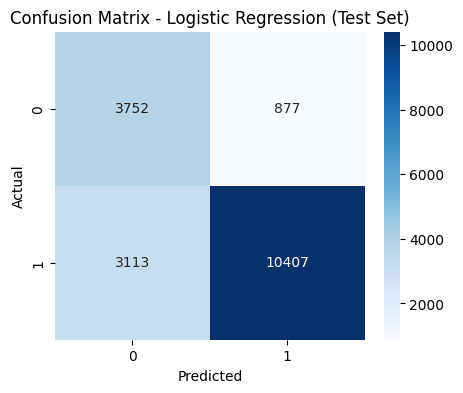

In [35]:

# Define and train the logistic regression model
#custom_weights = {0: 1, 1: 2.5} 
log_model = LogisticRegression(max_iter=1000,class_weight='balanced')
#log_model = LogisticRegression(max_iter=1000,class_weight=custom_weights)
log_model.fit(X_train_vec, y_train)

# Predictions
y_pred_train = log_model.predict(X_train_vec)
y_pred_test  = log_model.predict(X_test_vec)

# Accuracy
train_acc = accuracy_score(y_train, y_pred_train)
test_acc  = accuracy_score(y_test, y_pred_test)

print("Logistic Regression Training Accuracy:", round(train_acc, 4))
print("Logistic Regression Testing Accuracy :", round(test_acc, 4))

# Overfitting / Underfitting check
if train_acc - test_acc > 0.05:
    print("Status: Overfitting (training >> testing)")
elif test_acc - train_acc > 0.05:
    print("Status: Underfitting (testing >> training)")
else:
    print("Status: Good Fit (training ≈ testing)")

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=['Not Approved', 'Approved']))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Random Forest Training Accuracy: 0.9479
Random Forest Testing Accuracy : 0.8065

Classification Report (Test Set):
              precision    recall  f1-score   support

Not Approved       0.62      0.62      0.62      4629
    Approved       0.87      0.87      0.87     13520

    accuracy                           0.81     18149
   macro avg       0.75      0.75      0.75     18149
weighted avg       0.81      0.81      0.81     18149



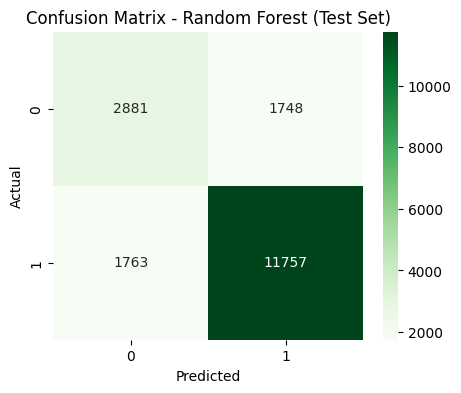

In [ ]:
#  Define and train the Random Forest model ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
rf_model.fit(X_train_vec, y_train)

# --- Predictions ---
y_pred_train = rf_model.predict(X_train_vec)
y_pred_test  = rf_model.predict(X_test_vec)

# --- Accuracy ---
train_acc = accuracy_score(y_train, y_pred_train)
test_acc  = accuracy_score(y_test, y_pred_test)

print("Random Forest Training Accuracy:", round(train_acc, 4))
print("Random Forest Testing Accuracy :", round(test_acc, 4))

# Overfitting / Underfitting check
if train_acc - test_acc > 0.05:
    print("Status: Overfitting (training >> testing)")
elif test_acc - train_acc > 0.05:
    print("Status: Underfitting (testing >> training)")
else:
    print("Status: Good Fit (training ≈ testing)")

# --- Classification Report ---
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=['Not Approved', 'Approved']))

# --- Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



Naive Bayes Training Accuracy: 0.7423
Naive Bayes Testing Accuracy : 0.7084
Status: Good Fit (training ≈ testing)

Classification Report (Test Set):
              precision    recall  f1-score   support

Not Approved       0.46      0.75      0.57      4629
    Approved       0.89      0.69      0.78     13520

    accuracy                           0.71     18149
   macro avg       0.67      0.72      0.67     18149
weighted avg       0.78      0.71      0.73     18149



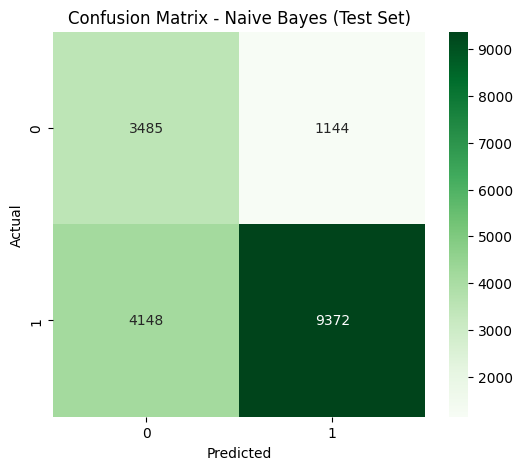

In [27]:
# --- Handle class imbalance using sample weights ---
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# --- Define and train the Naive Bayes model ---
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train, sample_weight=sample_weights)

# --- Predictions ---
y_pred_train = nb_model.predict(X_train_vec)
y_pred_test  = nb_model.predict(X_test_vec)

# --- Accuracy ---
train_acc = accuracy_score(y_train, y_pred_train)
test_acc  = accuracy_score(y_test, y_pred_test)

print("Naive Bayes Training Accuracy:", round(train_acc, 4))
print("Naive Bayes Testing Accuracy :", round(test_acc, 4))

# --- Overfitting / Underfitting check ---
if train_acc - test_acc > 0.05:
    print("Status: Overfitting (training >> testing)")
elif test_acc - train_acc > 0.05:
    print("Status: Underfitting (testing >> training)")
else:
    print("Status: Good Fit (training ≈ testing)")

# --- Classification Report ---
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=['Not Approved', 'Approved']))

# --- Confusion Matrix ---
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Naive Bayes (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Linear SVM Training Accuracy: 0.8718
Linear SVM Testing Accuracy : 0.781
Status: Overfitting (training >> testing)

Classification Report (Test Set):
              precision    recall  f1-score   support

Not Approved       0.55      0.78      0.64      4629
    Approved       0.91      0.78      0.84     13520

    accuracy                           0.78     18149
   macro avg       0.73      0.78      0.74     18149
weighted avg       0.82      0.78      0.79     18149



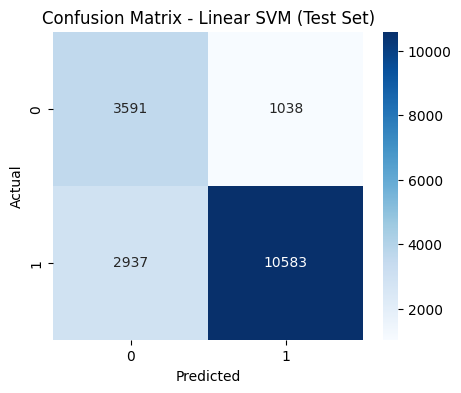

In [28]:
# --- Define and train the Linear SVM model ---
svm_model = LinearSVC(random_state=42, max_iter=5000,class_weight='balanced')
svm_model.fit(X_train_vec, y_train)

# --- Predictions ---
y_pred_train = svm_model.predict(X_train_vec)
y_pred_test  = svm_model.predict(X_test_vec)

# --- Accuracy ---
train_acc = accuracy_score(y_train, y_pred_train)
test_acc  = accuracy_score(y_test, y_pred_test)

print("Linear SVM Training Accuracy:", round(train_acc, 4))
print("Linear SVM Testing Accuracy :", round(test_acc, 4))

# --- Overfitting / Underfitting check ---
if train_acc - test_acc > 0.05:
    print("Status: Overfitting (training >> testing)")
elif test_acc - train_acc > 0.05:
    print("Status: Underfitting (testing >> training)")
else:
    print("Status: Good Fit (training ≈ testing)")

# --- Classification Report ---
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=['Not Approved', 'Approved']))

# --- Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Linear SVM (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



Passive-Aggressive Training Accuracy: 0.8841
Passive-Aggressive Testing Accuracy : 0.7564
Status: Overfitting (training >> testing)

Classification Report (Test Set):
              precision    recall  f1-score   support

Not Approved       0.52      0.74      0.61      4629
    Approved       0.90      0.76      0.82     13520

    accuracy                           0.76     18149
   macro avg       0.71      0.75      0.72     18149
weighted avg       0.80      0.76      0.77     18149



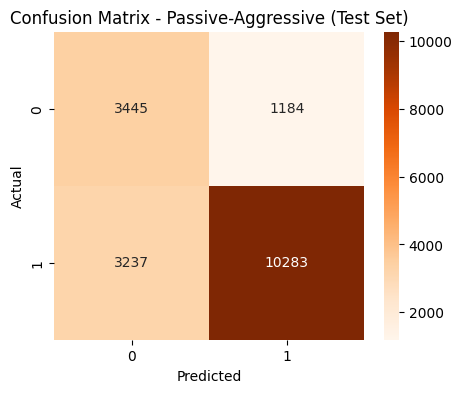

In [29]:
# ---Define and train the Passive-Aggressive model ---
pa_model = PassiveAggressiveClassifier(max_iter=1000, random_state=42,class_weight='balanced')
pa_model.fit(X_train_vec, y_train)

# --- Predictions ---
y_pred_train = pa_model.predict(X_train_vec)
y_pred_test  = pa_model.predict(X_test_vec)

# --- Accuracy ---
train_acc = accuracy_score(y_train, y_pred_train)
test_acc  = accuracy_score(y_test, y_pred_test)

print("Passive-Aggressive Training Accuracy:", round(train_acc, 4))
print("Passive-Aggressive Testing Accuracy :", round(test_acc, 4))

# --- Overfitting / Underfitting check ---
if train_acc - test_acc > 0.05:
    print("Status: Overfitting (training >> testing)")
elif test_acc - train_acc > 0.05:
    print("Status: Underfitting (testing >> training)")
else:
    print("Status: Good Fit (training ≈ testing)")

# --- Classification Report ---
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=['Not Approved', 'Approved']))

# --- Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Passive-Aggressive (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



                      Train    Test  Difference       Status
Logistic Regression  0.8257  0.7802      0.0455     Good Fit
Random Forest        0.9479  0.8065      0.1414  Overfitting
Naive Bayes          0.7423  0.7084      0.0339     Good Fit
Linear SVM           0.8718  0.7810      0.0908  Overfitting
Passive-Aggressive   0.8841  0.7564      0.1277  Overfitting


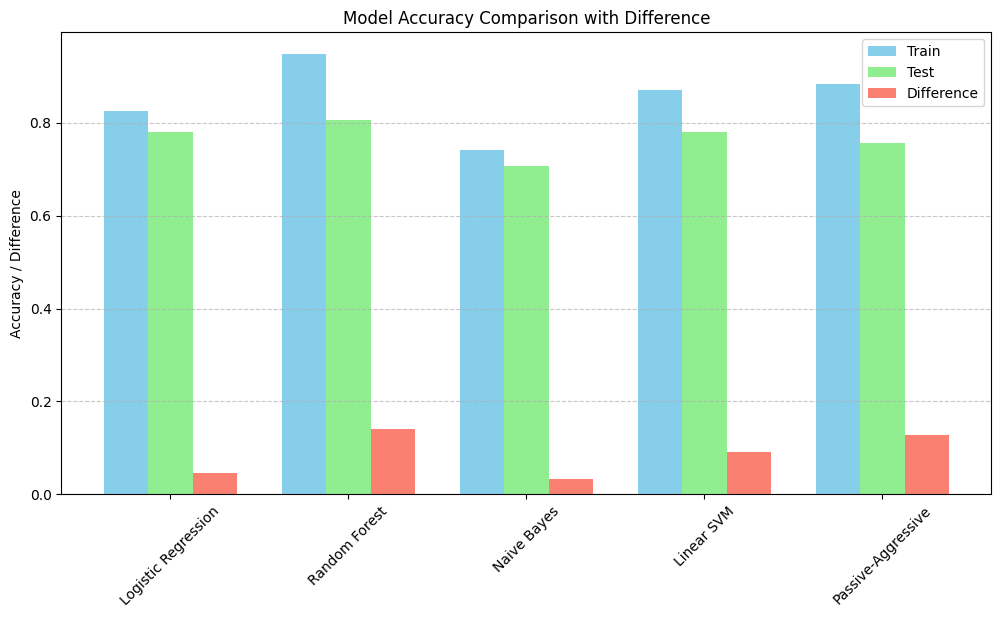

In [31]:
# --- Predictions ---
y_pred_log = log_model.predict(X_test_vec)
y_pred_rf  = rf_model.predict(X_test_vec)
y_pred_nb  = nb_model.predict(X_test_vec)
y_pred_svm = svm_model.predict(X_test_vec)
y_pred_pa  = pa_model.predict(X_test_vec)

# --- Create model scores dictionary ---
model_scores = {
    "Logistic Regression": {
        "Train": accuracy_score(y_train, log_model.predict(X_train_vec)),
        "Test": accuracy_score(y_test, y_pred_log)
    },
    "Random Forest": {
        "Train": accuracy_score(y_train, rf_model.predict(X_train_vec)),
        "Test": accuracy_score(y_test, y_pred_rf)
    },
    "Naive Bayes": {
        "Train": accuracy_score(y_train, nb_model.predict(X_train_vec)),
        "Test": accuracy_score(y_test, y_pred_nb)
    },
    "Linear SVM": {
        "Train": accuracy_score(y_train, svm_model.predict(X_train_vec)),
        "Test": accuracy_score(y_test, y_pred_svm)
    },
    "Passive-Aggressive": {
        "Train": accuracy_score(y_train, pa_model.predict(X_train_vec)),
        "Test": accuracy_score(y_test, y_pred_pa)
    }
}

# --- Convert to DataFrame ---
df_scores = pd.DataFrame(model_scores).T
df_scores["Difference"] = df_scores["Train"] - df_scores["Test"]  # Overfitting / Underfitting

# --- Add Status column ---
def fit_status(diff):
    if diff > 0.05:
        return "Overfitting"
    elif diff < -0.05:
        return "Underfitting"
    else:
        return "Good Fit"

df_scores["Status"] = df_scores["Difference"].apply(fit_status)



# Round for readability
df_scores = df_scores.round(4)

print(df_scores)


# --- Metrics to plot ---
metrics = ['Train', 'Test', 'Difference']
colors = ['skyblue', 'lightgreen', 'salmon']  # Train, Test, Difference

# --- Bar positions ---
x = np.arange(len(df_scores))  # positions for models
width = 0.25  # width of each bar

# --- Create figure ---
plt.figure(figsize=(12,6))

# Plot each metric
for i, metric in enumerate(metrics):
    plt.bar(x + i*width, df_scores[metric], width=width, color=colors[i], label=metric)

# --- Labels and title ---
plt.xticks(x + width, df_scores.index, rotation=45)
plt.ylabel("Accuracy / Difference")
plt.title("Model Accuracy Comparison with Difference")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [36]:
import pickle

# --- Save the Naive Bayes model ---
with open("log_model.pkl", "wb") as f:
    pickle.dump(nb_model, f)

# --- Save the TF-IDF vectorizer ---
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# --- Save the preprocessing function ---
with open("preprocess_text.pkl", "wb") as f:
    pickle.dump(preprocess_text, f)

print("Pickle files created successfully!")


Pickle files created successfully!
